In [1]:
import numpy as np
import scipy.optimize as opt
from sklearn.utils import resample
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

import pandas as pd


#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest, TrailingStopLossDetails
from oandapyV20.exceptions import V20Error, StreamTerminated
import sqlite3
from collections import OrderedDict, ChainMap
from IPython.display import clear_output
import arviz as az

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda_new2.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:



def get_data(granularity, instrument, save_csv=False):
    client = API(access_token="e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d")
    

    params = {

        "granularity": granularity,
        "count":700,
     }
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
            rv = client.request(r)
            results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                        "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                       "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                       } for candle in r.response.get('candles')]
            df = df.append(pd.DataFrame(results), ignore_index=True)

    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [5]:
df = get_data(instrument = "NAS100_USD", granularity = "M30", save_csv=False)
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-05-12T11:30:00,11875.0,11877.6,11754.2,11763.5,24050.0
2022-05-12T12:00:00,11763.6,11818.4,11755.6,11788.4,19697.0
2022-05-12T12:30:00,11788.7,11834.0,11759.8,11791.0,24178.0
2022-05-12T13:00:00,11791.0,11841.8,11772.7,11788.2,24976.0
2022-05-12T13:30:00,11788.3,11871.6,11690.8,11797.0,90433.0


In [6]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['Open'] = df['Open'].rolling(window=3).mean()  
    df_new['High'] = df['High'].rolling(window=3).mean()  
    df_new['Low'] = df['Low'].rolling(window=3).mean()
    df_new['Close'] = df['Close']
    df_new['Volume'] = df['Volume'].rolling(window=3).mean()
    df_new['pct_change'] = df['Close'].pct_change()
  
    
    df_new = df_new.dropna(axis=0)
    return df_new

In [7]:
df = generate_features(df)
df.tail()

,Open,High,Low,Close,Volume,pct_change
Date,,,,,,
2022-05-12T11:30:00,11869.600000,11889.466667,11805.566667,11763.5,20118.000000,-0.009389
2022-05-12T12:00:00,11834.133333,11870.466667,11784.966667,11788.4,21848.000000,0.002117
2022-05-12T12:30:00,11809.100000,11843.333333,11756.533333,11791.0,22641.666667,0.000221
2022-05-12T13:00:00,11781.100000,11831.400000,11762.700000,11788.2,22950.333333,-0.000237
2022-05-12T13:30:00,11789.333333,11849.133333,11741.100000,11797.0,46529.000000,0.000747


In [8]:
import pymc3 as pm
import pandas as pd



WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:


with pm.Model() as X_model:
    # The model remembers the datetime index with the name 'date'
    change_returns = pm.Data("returns", df["pct_change"], dims="date", export_index_as_coords=True)

    nu = pm.Exponential("nu", 1 / 10.0, testval=5.0)
    sigma = pm.Exponential("sigma", 2.0, testval=0.1)

    # We can now figure out the shape of variables based on the
    # index of the dataset
    s = pm.GaussianRandomWalk("s", sigma=sigma, dims="date")
    # instead of:
    # s = pm.GaussianRandomWalk('s', sigma, shape=len(returns))
    volatility_process = pm.Deterministic(
        "volatility_process", pm.math.exp(-2 * s) ** 0.5, dims="date"
    )

    r = pm.StudentT("r", nu=nu, sigma=volatility_process, observed=change_returns, dims="date")

In [10]:
with X_model:
    trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False, target_accept = .95)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 157 seconds.


0, dim: date, 698 =? 698


The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date, 698 =? 698
0, dim: date, 698 =? 698


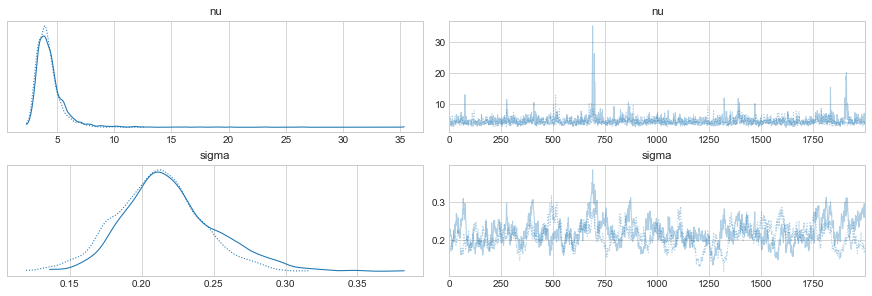

In [11]:
with X_model:
    az.plot_trace(trace, var_names=["nu", "sigma"]);

0, dim: date, 698 =? 698


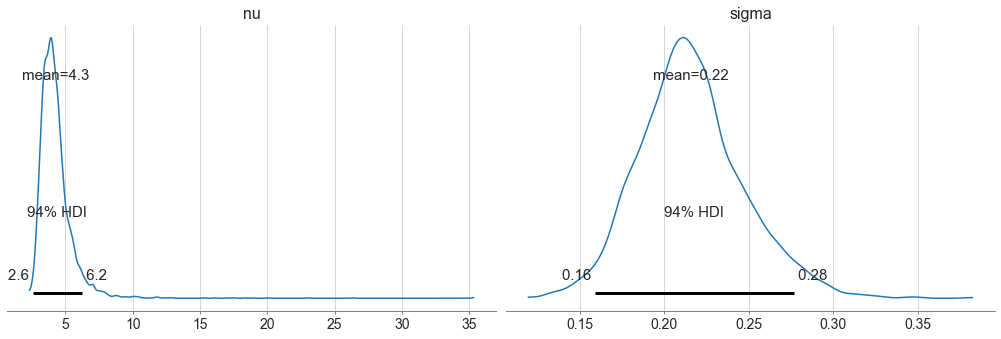

In [27]:
with X_model:
    az.plot_posterior(trace, var_names=["nu", "sigma"]);

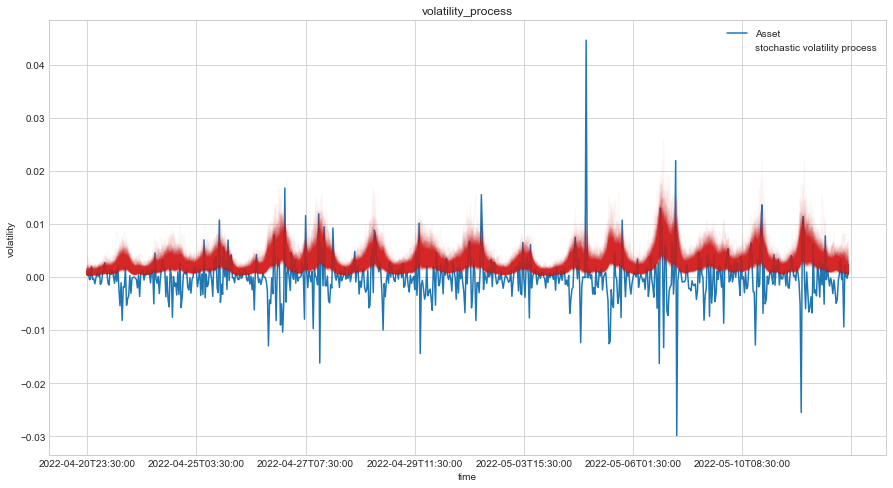

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
df["pct_change"].plot(ax=ax)
ax.plot(df["pct_change"].index, 1 / np.exp(trace["s", ::5].T), "C3", alpha=0.03)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["Asset", "stochastic volatility process"], loc="upper right");

In [14]:
pm.summary(trace, var_names=["nu", "sigma"])

0, dim: date, 698 =? 698


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,4.307,1.418,2.577,6.200,0.073,0.052,417.0,749.0,1.00
sigma,0.216,0.031,0.159,0.277,0.004,0.003,71.0,205.0,1.02


In [15]:
# I set a variable for the lenght of the dims and add the forecast period I want .... 
dims="date"

length = len(dims) + 40

In [29]:
length

44

In [17]:
# here I run the model for the new lenght and for the variable = mu 
posterior_pred = pm.sample_posterior_predictive(trace, length, var_names=['nu', 'sigma'], model= X_model)
posterior_pred

{'nu': array([3.7242232 , 3.09457289, 4.17654625, 5.52381755, 4.82857606,
        4.00400698, 4.40593642, 3.95930114, 3.03642445, 4.34013105,
        2.6473641 , 4.24535266, 3.01120009, 3.48200209, 2.88082806,
        2.75355976, 3.22437354, 3.86323635, 3.1132372 , 3.49902044,
        3.11917745, 2.52553496, 2.81667465, 3.18641523, 3.47645339,
        3.96973738, 4.35877227, 4.13791273, 3.78911582, 4.35921978,
        3.12494786, 3.2471373 , 3.32195408, 3.68376431, 6.43960585,
        5.4258666 , 6.02385377, 4.50532466, 5.52242702, 4.07220746,
        4.53098809, 4.22640463, 5.4042331 , 4.61156058]),
 'sigma': array([0.21980705, 0.21074875, 0.21926777, 0.22490779, 0.22861267,
        0.21359126, 0.21136676, 0.21392953, 0.21085824, 0.21196801,
        0.21286465, 0.20009481, 0.18726619, 0.1898774 , 0.19938983,
        0.18030495, 0.18276864, 0.20158479, 0.19553749, 0.20298698,
        0.19613846, 0.22496269, 0.20598625, 0.2140109 , 0.22978505,
        0.22423967, 0.24059689, 0.22377154,

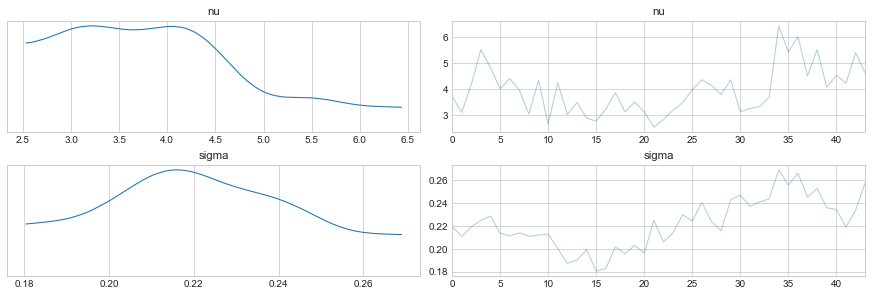

In [18]:
# after the trace was run the new mu is heading in the direction of around - 10 - so the current downtrend continous :-D
# I just wonder why the output is for 12 values and not for 10 like it was set in length .... 
import arviz as az
az.plot_trace(posterior_pred);

In [19]:
pm.summary((posterior_pred))

arviz - WARNING - Shape validation failed: input_shape: (1, 44), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,3.948,0.933,2.526,5.524,0.349,0.258,6.0,44.0,NaN
sigma,0.222,0.022,0.180,0.258,0.016,0.014,2.0,18.0,NaN
